In [1]:
import os
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, silhouette_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn_extra.cluster import KMedoids
import numpy as np
import seaborn as sns
from prompts import sentiment_clf_prompt, outcome_clf_prompt

os.environ["OPENAI_API_KEY"] = "xxx"

## Classification Pipeline using LangChain

In [2]:

tagging_prompt = ChatPromptTemplate.from_template(
    """
    Extract the desired information from the following passage.

    Only extract the properties mentioned in the 'Classification' function.

    Passage:

    {input}

    """)


# Structured output
class Classification(BaseModel):
    sentiment: str = Field(description=sentiment_clf_prompt, enum=['positive', 'negative', 'neutral'])
    outcome: str = Field(description=outcome_clf_prompt, enum=['issue resolved', 'follow-up action needed'])


# LLM 1
llm_mini = ChatOpenAI(temperature=0, model="gpt-4o-mini").with_structured_output(Classification)
# LLM 2
llm = ChatOpenAI(temperature=0, model="gpt-4o").with_structured_output(Classification)

# classification chain
tagging_chain_mini = tagging_prompt | llm_mini
tagging_chain = tagging_prompt | llm

## Functions to perform data loading, classification, and evaluation

In [3]:
def load_transcripts(path_to_data):
    """
    Load transcripts from text files in the specified directory.

    Args:
    path_to_data (str): Path to the directory containing transcript files.

    Returns:
    list: List of transcripts as strings.
    """
    data = []
    
    for file in os.listdir(path_to_data):
        if file.endswith(".txt"):
            with open(os.path.join(path_to_data, file), 'r') as f:
                data.append(f.read())
    return data


def transcripts_clf(transcripts: list[str], tagging_chain_):
    """
    Classify the sentiment and outcome of each transcript.

    Args:
    transcripts (list[str]): List of transcripts as strings.

    Returns:
    tuple: Two lists containing sentiment labels and outcome labels.
    """
    sentiment_labels, outcome_labels = [], []

    for transcript in transcripts:
        tags = tagging_chain_.invoke({"input": transcript})
        sentiment_labels.append(tags.sentiment)
        outcome_labels.append(tags.outcome)
            
    return sentiment_labels, outcome_labels


def evaluate_model_performance(labels, preds, label_names):
    """
    Evaluate the performance of the classification model.

    Args:
    labels (list): True labels.
    preds (list): Predicted labels.
    label_names (list): List of label names.

    Returns:
    tuple: Accuracy, F1 score, precision, recall, and confusion matrix.
    """
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    conf_matrix = confusion_matrix(labels, preds, labels=label_names)

    return acc, f1, precision, recall, conf_matrix


def plot_confusion_matrix(matrix, labels):
    fig, ax = plt.subplots()
    im = ax.imshow(matrix, cmap='Blues')

    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))

    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, matrix[i, j], ha="center", va="center", color="black")

    ax.set_title("Confusion Matrix")
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    fig.tight_layout()
    plt.show()


## Classification for tagged data

In [4]:
data = load_transcripts("transcripts_v3")
labels_df = pd.read_csv("transcripts_v3_labels/labels.csv")

sentiment_preds_mini, outcome_preds_mini = transcripts_clf(data[180:], tagging_chain_mini)
sentiment_preds_4o, outcome_preds_4o = transcripts_clf(data[180:], tagging_chain)

## Performance evaluation

### Gpt-4o

Sentiment Accuracy: 0.350
Sentiment F1 Score: 0.388
Sentiment Precision: 0.458
Sentiment Recall: 0.350


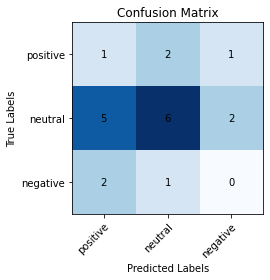

Outcome Accuracy: 0.450
Outcome F1 Score: 0.451
Outcome Precision: 0.455
Outcome Recall: 0.450


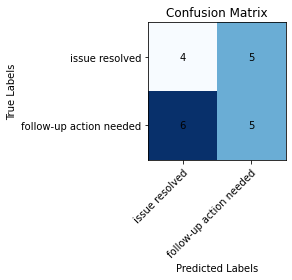

In [5]:
sentiment_labels = labels_df["sentiment"]
outcome_labels = labels_df["outcome"]

acc_s, f1_s, precision_s, recall_s, conf_matrix_s = evaluate_model_performance(sentiment_labels, sentiment_preds_4o, ["positive",  "neutral", "negative"])
acc_o, f1_o, precision_o, recall_o, conf_matrix_o = evaluate_model_performance(outcome_labels, outcome_preds_4o, ["issue resolved", "follow-up action needed"])

print(f"Sentiment Accuracy: {acc_s:.3f}")
print(f"Sentiment F1 Score: {f1_s:.3f}")
print(f"Sentiment Precision: {precision_s:.3f}")
print(f"Sentiment Recall: {recall_s:.3f}")
plot_confusion_matrix(conf_matrix_s, ["positive",  "neutral", "negative"])

print(f"Outcome Accuracy: {acc_o:.3f}")
print(f"Outcome F1 Score: {f1_o:.3f}")
print(f"Outcome Precision: {precision_o:.3f}")
print(f"Outcome Recall: {recall_o:.3f}")
plot_confusion_matrix(conf_matrix_o, ["issue resolved", "follow-up action needed"])


### Gpt-4o-mini

Sentiment Accuracy: 0.300
Sentiment F1 Score: 0.346
Sentiment Precision: 0.560
Sentiment Recall: 0.300


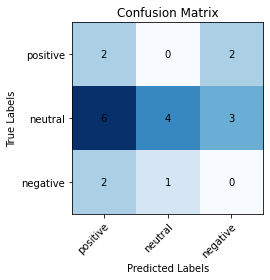

Outcome Accuracy: 0.450
Outcome F1 Score: 0.451
Outcome Precision: 0.455
Outcome Recall: 0.450


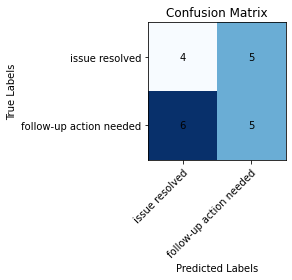

In [6]:
sentiment_labels = labels_df["sentiment"]
outcome_labels = labels_df["outcome"]

acc_s, f1_s, precision_s, recall_s, conf_matrix_s = evaluate_model_performance(sentiment_labels, sentiment_preds_mini, ["positive",  "neutral", "negative"])
acc_o, f1_o, precision_o, recall_o, conf_matrix_o = evaluate_model_performance(outcome_labels, outcome_preds_mini, ["issue resolved", "follow-up action needed"])

print(f"Sentiment Accuracy: {acc_s:.3f}")
print(f"Sentiment F1 Score: {f1_s:.3f}")
print(f"Sentiment Precision: {precision_s:.3f}")
print(f"Sentiment Recall: {recall_s:.3f}")
plot_confusion_matrix(conf_matrix_s, ["positive",  "neutral", "negative"])

print(f"Outcome Accuracy: {acc_o:.3f}")
print(f"Outcome F1 Score: {f1_o:.3f}")
print(f"Outcome Precision: {precision_o:.3f}")
print(f"Outcome Recall: {recall_o:.3f}")
plot_confusion_matrix(conf_matrix_o, ["issue resolved", "follow-up action needed"])

## Classification of all data using best model

This part assumes classification of tagged data has been performed

In [7]:
sentiment_preds_all, outcome_preds_all = transcripts_clf(data[0:180], tagging_chain)

sentiment_preds = sentiment_preds_all + sentiment_preds_4o
outcome_preds = outcome_preds_all + outcome_preds_4o

## Insights using TF-IDF, and Clustering

- Create custom stop words for tokenization
- Vectorization using TF-IDF
- Define k's to be tested: [2,3,4,5,6,7,8,10]
- For each k:
    - Perform clustering
    - Calculate silhouette score
    - Calculate WCSS   
- Plot Silhouette scores and WCSS for each k to pick best

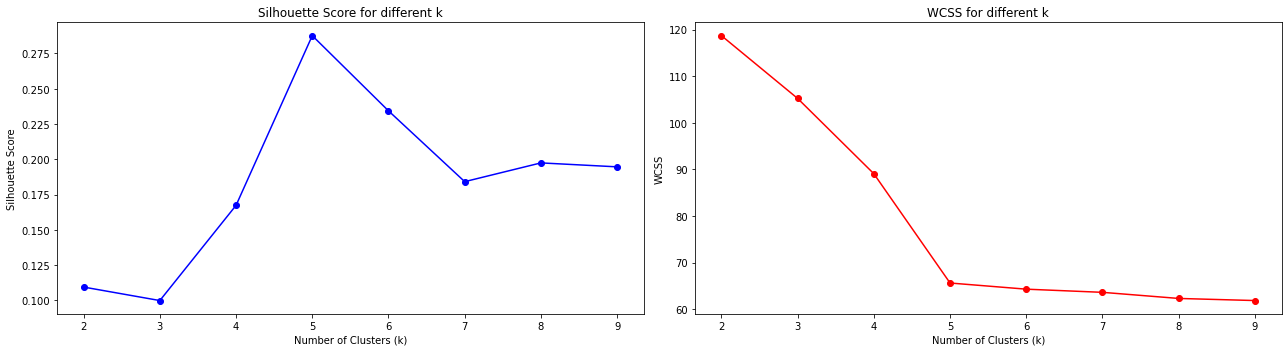

In [8]:
# Pre-defined stop words
stop_words = [
    "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", 
    "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "cannot", "could", 
    "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
    "have", "having", "he", "her", "here", "hers", "herself", "him", "himself", "his", "how", "i", "if", "in", 
    "into", "is", "it", "its", "itself", "me", "more", "most", "my", "myself", "no", "nor", "not", "of", "off", 
    "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", 
    "she", "so", "some", "such", "than", "that", "the", "their", "theirs", "them", "themselves", "then", 
    "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", 
    "we", "were", "what", "when", "where", "which", "while", "who", "whom", "why", "with", "would", "you", 
    "your", "yours", "yourself", "yourselves",

    # Customer support specific terms
    "please", "thank", "thanks", "sorry", "apologies", "appreciate", "assist", "assistance", "help", "issue", 
    "problem", "concern", "call", "called", "calling", "wait", "hold", "transfer", "transferred", "connect", 
    "connected", "disconnect", "disconnected", "contact", "contacted", "speaking", "speak", "said", "hear", 
    "heard", "listen", "listened", "checking", "checked", "answer", "answered", "support", "customer", 
    "service", "agent", "representative", "team", "line", "case", "number", "account", "id", "verify", 
    "verified", "verification", "helpful", "resolve", "resolved", "solution", "options", "option", "look", 
    "looking", "sure", "right", "okay", "yes", "yeah", "no", "uh", "um", "oh", "alright", "hello", "hi", 
    "hey", "good", "morning", "afternoon", "evening", "bye", "goodbye", "okay", "please hold", "let", "check", 
    "just", "moment", "second", "welcome", "member", "anything", "else", "great", "awesome", "pa",
    "technical"
]

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, sublinear_tf=True, max_df=0.8, min_df=0.1)
X = tfidf_vectorizer.fit_transform(data)

# Range of k values for k-medoids clustering
k_values = range(2, 10)

# Initialize lists for storing WCSS and silhouette scores
silhouette_scores = []
wcss_values = []

for k in k_values:
    # Perform k-medoids clustering
    kmedoids = KMedoids(n_clusters=k, random_state=0, metric="cosine").fit(X)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, kmedoids.labels_)
    silhouette_scores.append(silhouette_avg)
    
    # Calculate WCSS (Within-cluster Sum of Squares)
    wcss_values.append(kmedoids.inertia_)

# Plot silhouette scores and WCSS values
plt.figure(figsize=(18, 5))

# Silhouette score plot
plt.subplot(1, 2, 1)
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for different k")

# WCSS plot
plt.subplot(1, 2, 2)
plt.plot(k_values, wcss_values, marker='o', linestyle='-', color='r')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.title("WCSS for different k")

plt.tight_layout()
plt.show()



## Top terms per cluster using best k

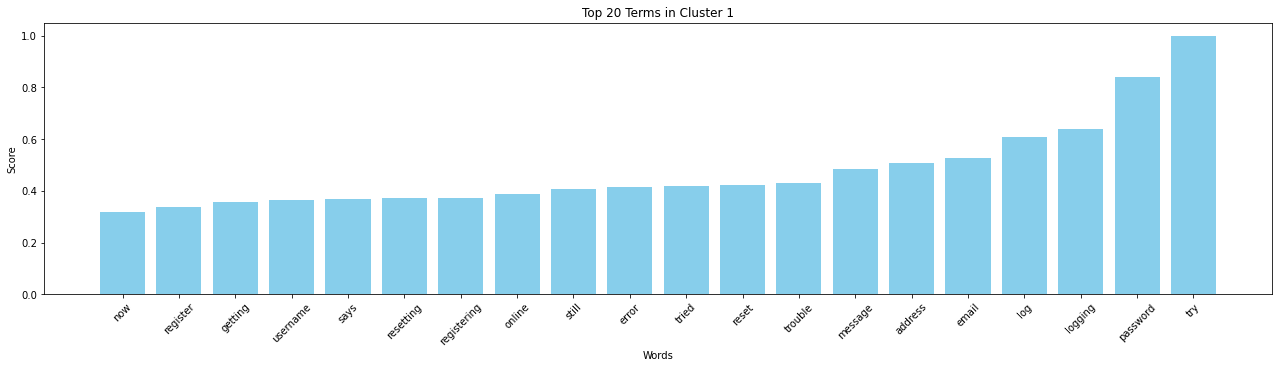

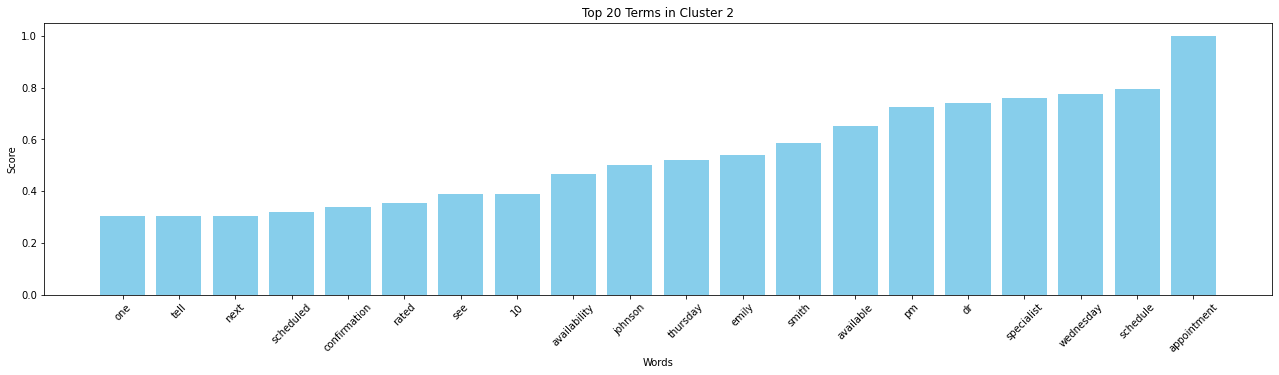

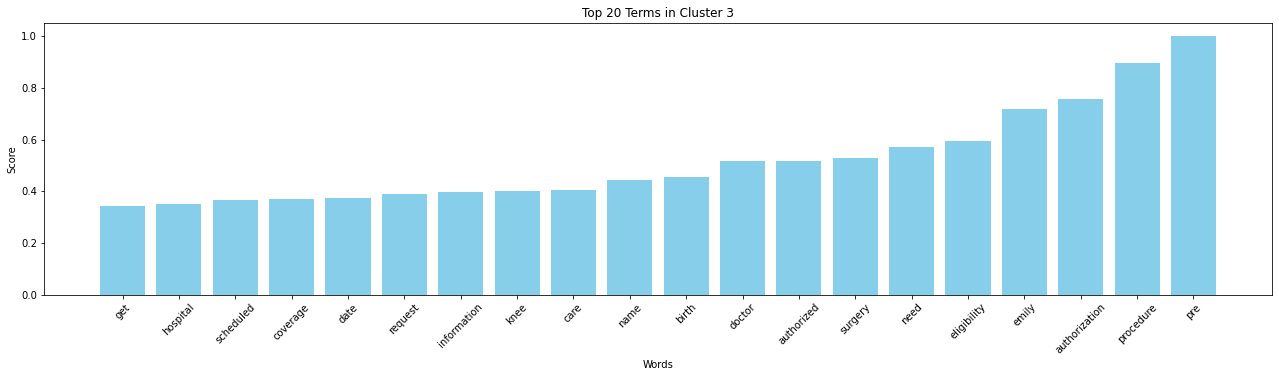

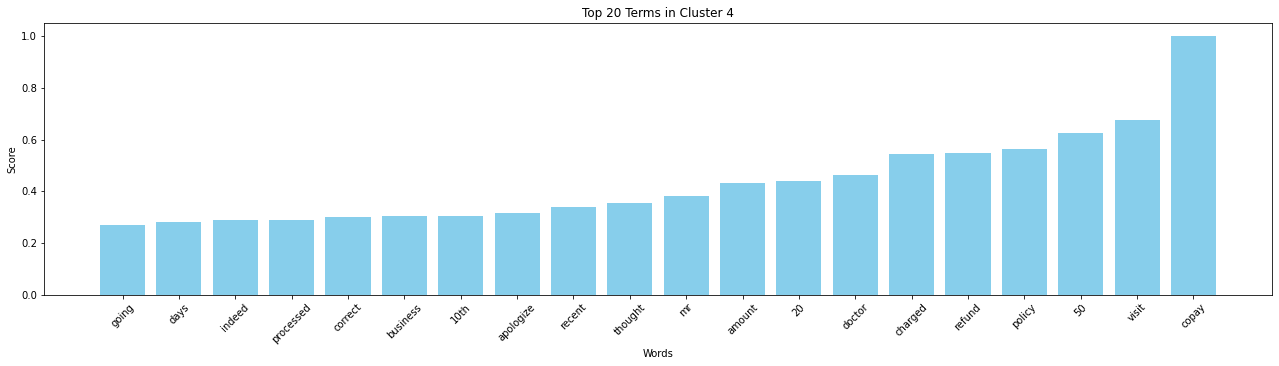

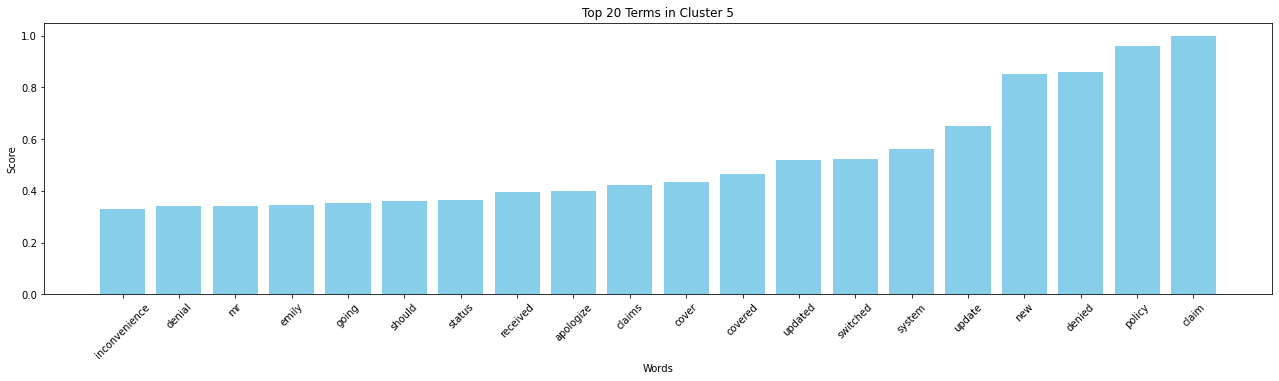

In [9]:
best_k = 5
best_kmedoids = KMedoids(n_clusters=best_k, random_state=0, metric="cosine").fit(X)

terms = np.array(tfidf_vectorizer.get_feature_names_out())

# Generate word clouds for each cluster
for cluster in range(best_k):

    # Extract top terms with highest tf-idf scores for the current cluster
    cluster_indices = np.where(best_kmedoids.labels_ == cluster)[0]
    mean_tfidf_scores = X[cluster_indices].mean(axis=0).A1
    relative_cluster_tfidf_scores = mean_tfidf_scores / np.max(mean_tfidf_scores)

    sorted_indexes = np.argsort(relative_cluster_tfidf_scores)

    top_cluster_terms = terms[sorted_indexes[-20:]]
    top_cluster_scores = relative_cluster_tfidf_scores[sorted_indexes[-20:]]
    
    # Plot bar chart
    plt.figure(figsize=(22, 5))
    plt.bar(top_cluster_terms, top_cluster_scores, color='skyblue')
    plt.xlabel('Words')
    plt.ylabel('Score')
    plt.title(f'Top 20 Terms in Cluster {cluster + 1}')
    plt.xticks(rotation=45)
    plt.show()


## Distribution of predicted sentiment and outcomes per cluster

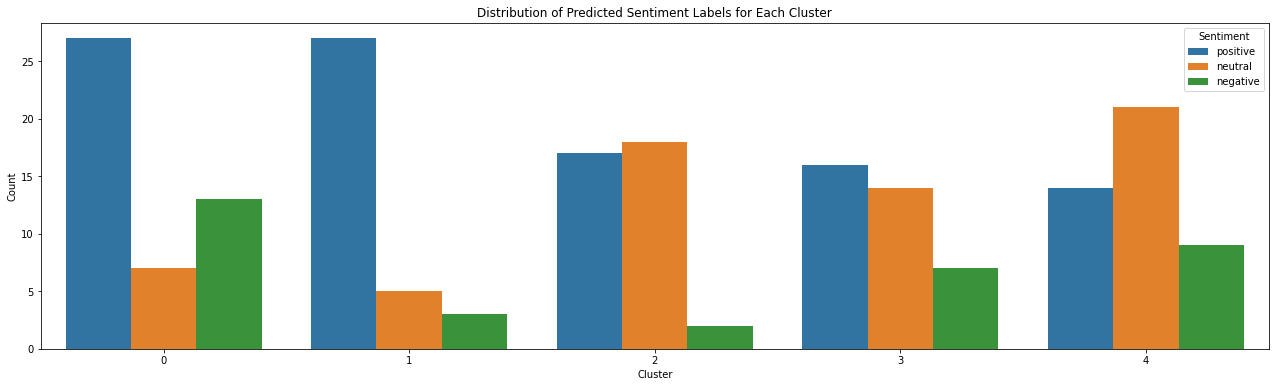

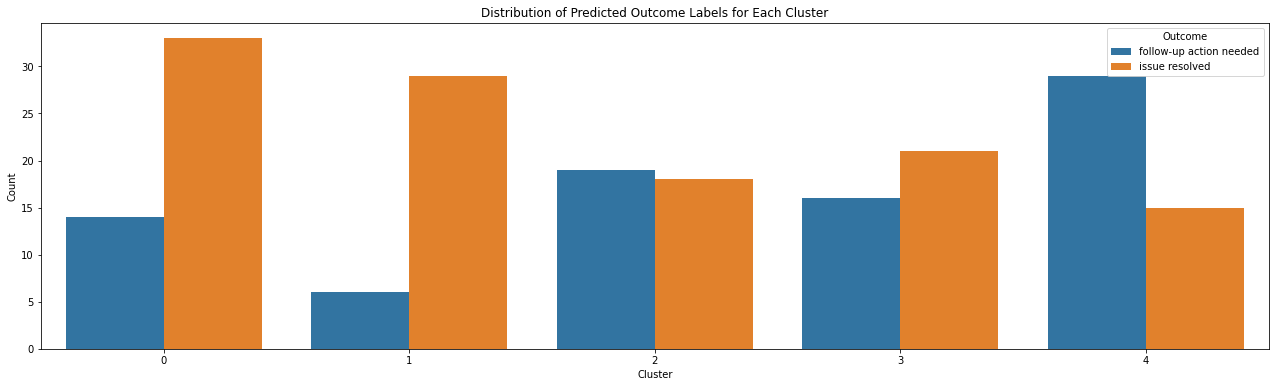

In [10]:


# Create a DataFrame with the cluster labels and predicted labels
df_clusters = pd.DataFrame({
    'Cluster': best_kmedoids.labels_,
    'Sentiment': sentiment_preds,
    'Outcome': outcome_preds
})

# Plot the distribution of predicted sentiment labels for each cluster
plt.figure(figsize=(22, 6))
sns.countplot(data=df_clusters, x='Cluster', hue='Sentiment')
plt.title('Distribution of Predicted Sentiment Labels for Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

# Plot the distribution of predicted outcome labels for each cluster
plt.figure(figsize=(22, 6))
sns.countplot(data=df_clusters, x='Cluster', hue='Outcome')
plt.title('Distribution of Predicted Outcome Labels for Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Outcome')
plt.show()